# Model Creation and Evaluation

In this report we create three regression models to predict the error vectors (both magnitude and angle), compare them with a baseline model, and evaluate the model performance by visualizing the mean-absolute error and means-quared error for both magnitudes and angles of the error vectors.

In [1]:
# Load packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load custom modules
import plotting_tools as pt

In [2]:
# Set the style of display
plt.style.use("ggplot")
%matplotlib inline

In [3]:
data = pd.read_csv('./data/image_database.txt')

In [4]:
data.columns

Index([u'starname', u'ra_act', u'dec_act', u'x_act_mx1', u'x_act_mx2',
       u'x_act_mx3', u'x_act_my3', u'x_act_my4', u'x_act_px1', u'x_act_px2',
       u'x_act_px3', u'x_act_py1', u'x_act_py2', u'x_act_py3', u'x_act_py4',
       u'x_img_mx1', u'x_img_mx2', u'x_img_mx3', u'x_img_my3', u'x_img_my4',
       u'x_img_px1', u'x_img_px2', u'x_img_px3', u'x_img_py1', u'x_img_py2',
       u'x_img_py3', u'x_img_py4', u'y_act_mx1', u'y_act_mx2', u'y_act_mx3',
       u'y_act_my3', u'y_act_my4', u'y_act_px1', u'y_act_px2', u'y_act_px3',
       u'y_act_py1', u'y_act_py2', u'y_act_py3', u'y_act_py4', u'y_img_mx1',
       u'y_img_mx2', u'y_img_mx3', u'y_img_my3', u'y_img_my4', u'y_img_px1',
       u'y_img_px2', u'y_img_px3', u'y_img_py1', u'y_img_py2', u'y_img_py3',
       u'y_img_py4', u'v_global_x', u'v_global_y', u'v_global_z',
       u'err_mag_mx3', u'err_r_mx3', u'err_ang_mx3', u'err_mag_py3',
       u'err_r_py3', u'err_ang_py3', u'err_mag_my3', u'err_r_my3',
       u'err_ang_my3', u'err_mag_p

In [5]:
def fetch_data(camera, image_num):
    """ Fetches the star data from a given image taken from a given camera
    Parameters
    ----------
    camera : str
        The camera name
    image_num: str
        The number of an image from a camera. 
        If set to ".", all the images will be returned
        
    Returns
    -------
    Pandas.DataFrames
        Returns a data fram with NaN entries removed
    """
    # Load all the star data
    data = pd.read_csv('./data/image_database.txt')
    
    # Fetch the data of interest set by "camera" and "image_num"
    regex_txt = "err_.*" + camera + image_num
    df = data.filter(regex=regex_txt)
    
    return df

In [6]:
# Fetch all the data taken from camera "mx" 
camera = "mx"
image_num = "."

df = fetch_data(camera, image_num)
df.head()

,err_mag_mx3,err_r_mx3,err_ang_mx3,err_mag_mx2,err_r_mx2,err_ang_mx2,err_mag_mx1,err_r_mx1,err_ang_mx1
0,NaN,NaN,84.859260,NaN,NaN,84.859260,NaN,NaN,84.859260
1,NaN,NaN,34.887684,NaN,NaN,34.887684,NaN,NaN,34.887684
2,NaN,NaN,94.018541,NaN,NaN,94.018541,NaN,NaN,94.018541
3,NaN,NaN,93.243282,NaN,NaN,93.243282,NaN,NaN,93.243282
4,NaN,NaN,93.064243,NaN,NaN,93.064243,NaN,NaN,93.064243


In [7]:
df.describe()

,err_mag_mx3,err_r_mx3,err_ang_mx3,err_mag_mx2,err_r_mx2,err_ang_mx2,err_mag_mx1,err_r_mx1,err_ang_mx1
count,112.000000,112.000000,98.000000,115.000000,115.000000,98.000000,21.000000,21.000000,98.000000
mean,1.708790,542.145293,101.438478,2.156539,531.218733,101.438478,0.929675,563.367564,101.438478
std,0.727047,263.917057,27.460691,0.625118,251.130435,27.460691,0.611878,186.577424,27.460691
min,0.111400,9.102225,15.155884,0.386588,9.218313,15.155884,0.082680,156.328580,15.155884
25%,1.263753,348.696906,82.916111,1.643794,356.533943,82.916111,0.627360,532.972339,82.916111
50%,1.744043,606.238980,105.832814,2.153845,596.907934,105.832814,0.823817,613.679713,105.832814
75%,2.171537,745.952198,116.660812,2.685418,740.612167,116.660812,1.076075,658.501959,116.660812
max,3.359036,1013.690734,170.359913,3.149516,1009.864620,170.359913,3.119703,816.381060,170.359913


### Create Features and Split the Data 

In [8]:
def prepare_data(df, camera, image_nums=["1", "2"]):
    """ Prepares the data for training and testing
    """
    x = []
    y = []
    for l in image_nums:
            regex_txt = "err_.*" + camera + l
            dfn = df.filter(regex=regex_txt)
            dfn.dropna(inplace=True)
            cols = ["err_mag_" + camera + l, "err_ang_"+ camera + l]
            df_tmp = dfn.loc[:, cols]
            y.append(df_tmp.as_matrix())
            #cols = ["err_r_" + camera + l, "x_img_" + camera + l, "y_img_" + camera + l]
            cols = ["err_r_" + camera + l]
            df_tmp = dfn.loc[:, cols]
            x.append(df_tmp.as_matrix())
            
    y = np.vstack(tuple(y))
    x = np.vstack(tuple(x))
    return x, y

#y_train = np.reshape(df.err_mag_mx2.as_matrix(), (df.shape[0], 1))
#x_train = np.reshape(df.err_r_mx2.as_matrix(), (df.shape[0], 1))

# Create the training and test datasets
X_train, y_train = prepare_data(df, camera, image_nums=["1", "2"])
X_test, y_test = prepare_data(df, camera, image_nums=["3"])

# Create polynomial features
#from sklearn import preprocessing
#x_train_poly = np.hstack((x_train, np.power(x_train,2), np.power(x_train,3)))
#poly = preprocessing.PolynomialFeatures(degree=3, interaction_only=False, include_bias=True)
#x_train_poly=poly.fit_transform(x_train)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 49 samples.
Testing set has 41 samples.


/home/sd-spare/muhammad/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Build Models

#### Build a pipeline for model evaluation

In [9]:
# Calculate MAE and MSE of the baseline model
baseline_prediction_MAE_train = np.mean(np.abs(y_train - np.mean(y_train, axis=0)), axis=0)
baseline_prediction_MAE_test = np.mean(np.abs(y_test - np.mean(y_test, axis=0)), axis=0)
baseline_prediction_MSE_train = np.square(np.abs(y_train - np.mean(y_train, axis=0))).mean(axis=0)
baseline_prediction_MSE_test = np.square(np.abs(y_test - np.mean(y_test, axis=0))).mean(axis=0)
baseline_error_dict = {"baseline_prediction_MAE_train":baseline_prediction_MAE_train,
                       "baseline_prediction_MAE_test":baseline_prediction_MAE_test,
                       "baseline_prediction_MSE_train":baseline_prediction_MSE_train,
                       "baseline_prediction_MSE_test":baseline_prediction_MSE_test}
baseline_error_mag_dict = {ky:baseline_error_dict[ky][0] for ky in baseline_error_dict.keys()}
baseline_error_ang_dict = {ky:baseline_error_dict[ky][1] for ky in baseline_error_dict.keys()}

In [10]:
baseline_error_dict

{'baseline_prediction_MAE_test': array([  0.56093514,  14.07399449]),
 'baseline_prediction_MAE_train': array([  0.58636579,  16.52739317]),
 'baseline_prediction_MSE_test': array([  4.53528997e-01,   5.59692540e+02]),
 'baseline_prediction_MSE_train': array([  5.07330743e-01,   7.11988208e+02])}

#### Build a baseline model

In [11]:
# use mean absolute error as model eveluation metrix
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    """
    Parameters
    ----------
    learner :  
        the learning algorithm to be trained and predicted on
    sample_size : int
        the size of samples (number) to be drawn from training set
    X_train : Pandas.DataFrame 
        predictors in training set
    y_train : Pandas.DataFrame
        response in training set
    X_test : Pandas.DataFrame
        predictors in testing set
    y_test : Pandas.DataFrame
        response in testing set
        
    Returns
    -------
    dict
        a dictionalry object that holdes various results related to model eveluation 
    """
    
    from time import time
    
    results = {}
    
    # fit the learner to the training data using slicing with 'sample_size'
    X_train_sample = X_train[:sample_size, :]
    y_train_sample = y_train[:sample_size, :]
    start = time() # Get start time
    learner = learner.fit(X_train_sample, y_train_sample)
    end = time() # Get end time
    
    # calculate the training time
    results['train_time'] = [end - start] * y_train.shape[1]
        
    # get the predictions on the test set,
    # then get predictions on the training set
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train_sample)
    end = time() # Get end time
    
    # store the predictions
    results['yhat_train'] = predictions_train
    results['yhat_test'] = predictions_test
    
    # calculate the total prediction time
    results['pred_time'] = [end-start] * y_train.shape[1]
            
    # compute mean_absolute_error on the training and testing sets
    #results['mean_absolute_error_train'] = mean_absolute_error(predictions_train, y_train_sample)
    #results['mean_absolute_error_test'] = mean_absolute_error(predictions_test, y_test)
    results['mean_absolute_error_train'] = np.mean(np.abs(y_train_sample - np.mean(predictions_train, axis=0)), axis=0)
    results['mean_absolute_error_test'] = np.mean(np.abs(y_test - np.mean(predictions_test, axis=0)), axis=0)

    # compute mean_squared_error on the training and testing sets
    #results['mean_squared_error_train'] = mean_squared_error(predictions_train, y_train_sample)
    #results['mean_squared_error_test'] = mean_squared_error(predictions_test, y_test)
    results['mean_squared_error_train'] = np.square(np.abs(y_train_sample - np.mean(predictions_train, axis=0))).mean(axis=0)
    results['mean_squared_error_test'] = np.square(np.abs(y_test - np.mean(predictions_test, axis=0))).mean(axis=0)   
    # some info messages
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # return the results
    return results

#### Build three regression models

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# Initialize the three models
# build a linear regression
clf_LR = LinearRegression()

# Fit a linear regression model
#LR = linear_model.LinearRegression(normalize=True)
#LR.fit(x_train_poly, y_train)

# build a GradientBoosting Regressor model
clf_GB = GradientBoostingRegressor(loss="ls", learning_rate=0.1, n_estimators=10, random_state=16)

# build a Random Forest model
clf_RF = RandomForestRegressor(n_estimators=10, random_state=16)

## Model Evaluation

#### Evaluate the above three model results in terms of mean-absolute error (MAE) and mean-squared error (MSE) of the error vector magnitude

MultiOutputRegressor trained on 14 samples.
MultiOutputRegressor trained on 24 samples.
MultiOutputRegressor trained on 49 samples.
MultiOutputRegressor trained on 14 samples.
MultiOutputRegressor trained on 24 samples.
MultiOutputRegressor trained on 49 samples.
MultiOutputRegressor trained on 14 samples.
MultiOutputRegressor trained on 24 samples.
MultiOutputRegressor trained on 49 samples.


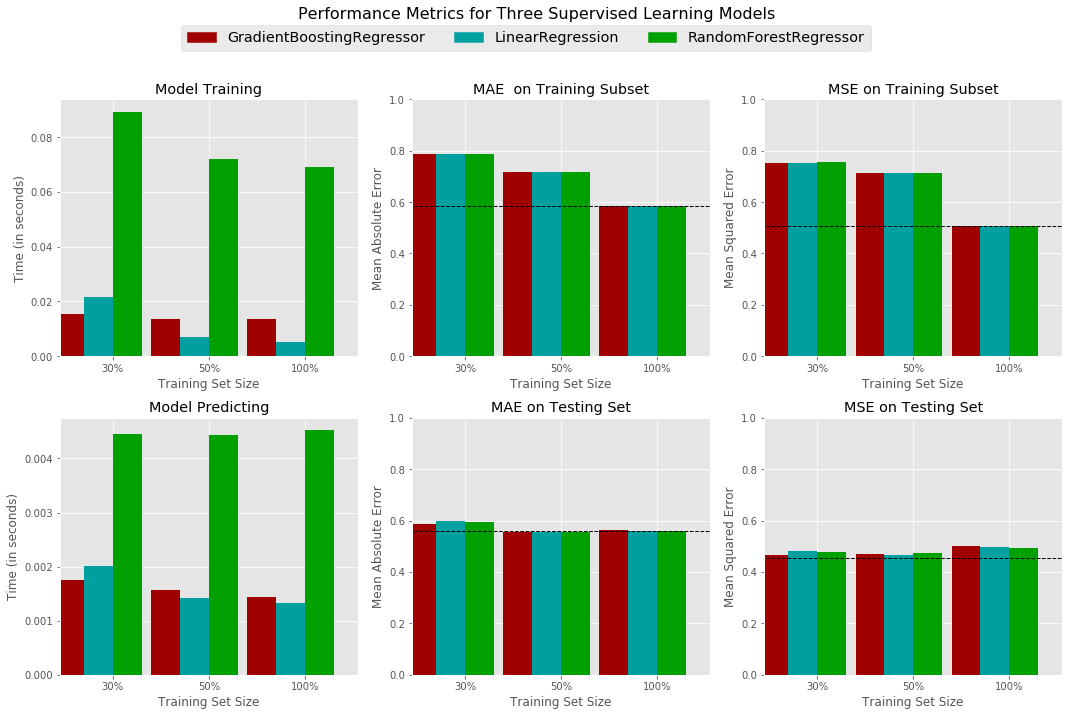

In [13]:
# calculate the number of samples for 1%, 10%, and 100% of the training data
samples_30 = int(0.3 * len(X_train))
samples_50 = int(0.5 * len(X_train))
samples_100 = len(X_train)

# collect results on the learners
results = {}
for clf in [clf_LR, clf_GB, clf_RF]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    clf = MultiOutputRegressor(clf)
    for i, samples in enumerate([samples_30, samples_50, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
# Run metrics visualization for the three models
pt.evaluate(results, baseline_error_mag_dict, params="magnitude")

In [14]:
results

{'GradientBoostingRegressor': {0: {'mean_absolute_error_test': array([  0.58621044,  15.45510463]),
   'mean_absolute_error_train': array([  0.78587825,  13.47168231]),
   'mean_squared_error_test': array([  4.68148744e-01,   5.70909519e+02]),
   'mean_squared_error_train': array([   0.75149629,  277.4312296 ]),
   'pred_time': [0.0017440319061279297, 0.0017440319061279297],
   'train_time': [0.015511035919189453, 0.015511035919189453],
   'yhat_test': array([[   2.00889726,  116.24754022],
          [   1.82454593,  118.30270241],
          [   1.48902887,  109.55977217],
          [   1.82454593,  118.30270241],
          [   1.44156705,   98.2558999 ],
          [   1.36535064,  109.75270738],
          [   1.65044008,  118.06160349],
          [   2.00889726,  116.24754022],
          [   1.44156705,   98.2558999 ],
          [   1.44156705,   98.2558999 ],
          [   2.13872982,  102.9122137 ],
          [   0.71718042,  105.0345262 ],
          [   1.44156705,   98.2558999 ],


#### Evaluate the above three model results in terms of absolute error (AE) of the error vector magnitude

(0, 3.0)

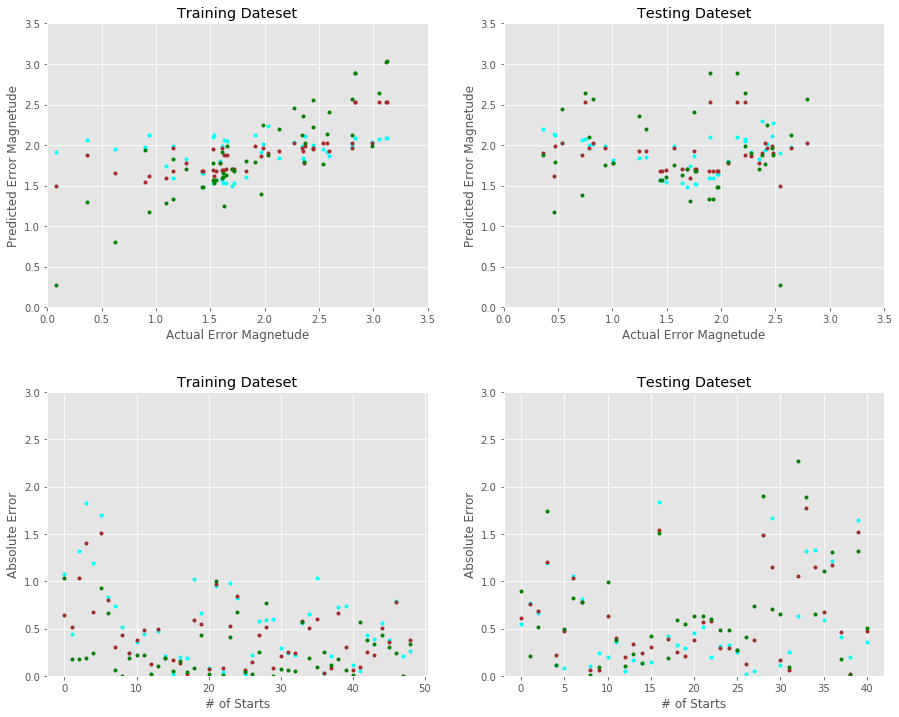

In [15]:
fig, axes = plt.subplots(2,2, figsize=(15,12))
plt.subplots_adjust(hspace=0.3)
colors = ['cyan', 'brown', 'green']
for i, clf in enumerate([clf_LR, clf_GB, clf_RF]):
    # Plot the predicted error magnitude vs "true" error magnitude for training data
    clf_name = clf.__class__.__name__
    yhat_train = results[clf_name][2]["yhat_train"]
    axes[0,0].plot(y_train[:,0], yhat_train[:,0], '.', color=colors[i])
    axes[0,0].set_xlabel("Actual Error Vec. Magnetude")
    axes[0,0].set_ylabel("Predicted Error Vec. Magnetude")
    axes[0,0].set_title("Training Dateset")
    
    # Plot the predicted error magnitude vs "true" error magnitude for testing data
    yhat_test = results[clf_name][2]["yhat_test"]
    axes[0,1].plot(y_test[:, 0], yhat_test[:, 0], '.', color=colors[i])
    axes[0,1].set_xlabel("Actual Error Vec. Magnetude")
    axes[0,1].set_ylabel("Predicted Error Vec. Magnetude")
    axes[0,1].set_title("Testing Dateset")
    
    # Plot the MAE for training data
    AE_train = np.abs(yhat_train[:, 0] - y_train[:, 0])
    axes[1,0].plot(AE_train, '.', color=colors[i])
    axes[1,0].set_ylabel("Absolute Error")
    axes[1,0].set_xlabel("# of Starts")
    axes[1,0].set_title("Training Dateset")
    
    # Plot the MAE for testing data
    AE_test = np.abs(yhat_test[:, 0] - y_test[:, 0])
    axes[1,1].plot(AE_test, '.', color=colors[i])
    axes[1,1].set_ylabel("Absolute Error")
    axes[1,1].set_xlabel("# of Starts")
    axes[1,1].set_title("Testing Dateset")
    
axes[0,0].set_xlim([0, 3.5])
axes[0,1].set_xlim([0, 3.5])
axes[0,0].set_ylim([0, 3.5])
axes[0,1].set_ylim([0, 3.5])
axes[1,0].set_ylim([0, 3.0])
axes[1,1].set_ylim([0, 3.0])

In [20]:
#### Evaluate the above three model results in terms of absolute error (AE) of the error vector angle

(0, 90)

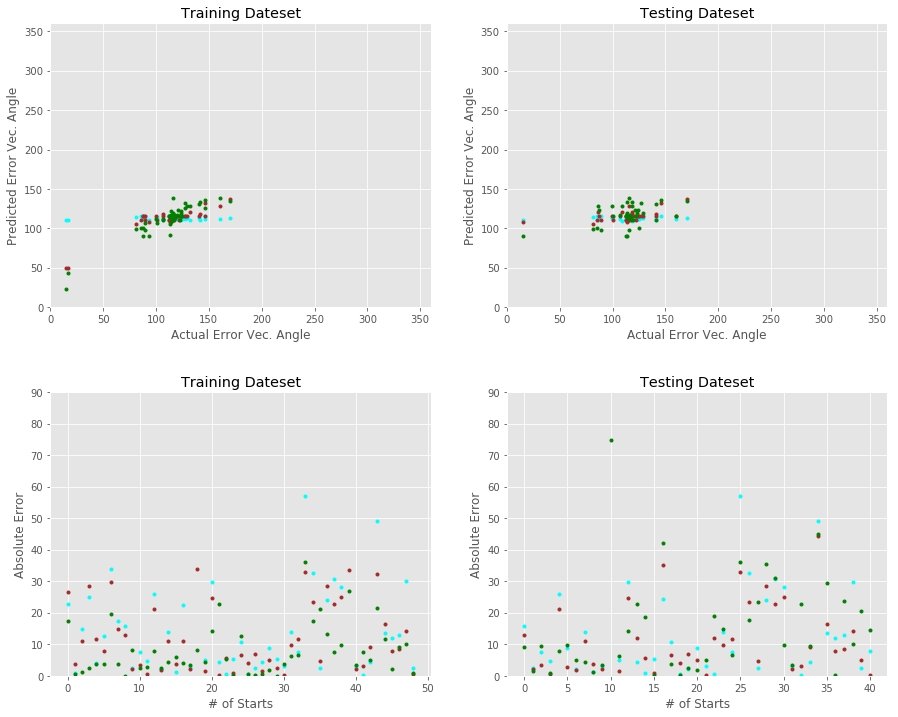

In [24]:
fig, axes = plt.subplots(2,2, figsize=(15,12))
plt.subplots_adjust(hspace=0.3)
colors = ['cyan', 'brown', 'green']
for i, clf in enumerate([clf_LR, clf_GB, clf_RF]):
    # Plot the predicted error magnitude vs "true" error magnitude for training data
    clf_name = clf.__class__.__name__
    yhat_train = results[clf_name][2]["yhat_train"]
    axes[0,0].plot(y_train[:,1], yhat_train[:,1], '.', color=colors[i])
    axes[0,0].set_xlabel("Actual Error Vec. Angle")
    axes[0,0].set_ylabel("Predicted Error Vec. Angle")
    axes[0,0].set_title("Training Dateset")
    
    # Plot the predicted error magnitude vs "true" error magnitude for testing data
    yhat_test = results[clf_name][2]["yhat_test"]
    axes[0,1].plot(y_test[:, 1], yhat_test[:, 1], '.', color=colors[i])
    axes[0,1].set_xlabel("Actual Error Vec. Angle")
    axes[0,1].set_ylabel("Predicted Error Vec. Angle")
    axes[0,1].set_title("Testing Dateset")
    
    # Plot the MAE for training data
    AE_train = np.abs(yhat_train[:, 1] - y_train[:, 1])
    axes[1,0].plot(AE_train, '.', color=colors[i])
    axes[1,0].set_ylabel("Absolute Error")
    axes[1,0].set_xlabel("# of Starts")
    axes[1,0].set_title("Training Dateset")
    
    # Plot the MAE for testing data
    AE_test = np.abs(yhat_test[:, 1] - y_test[:, 1])
    axes[1,1].plot(AE_test, '.', color=colors[i])
    axes[1,1].set_ylabel("Absolute Error")
    axes[1,1].set_xlabel("# of Starts")
    axes[1,1].set_title("Testing Dateset")
    
axes[0,0].set_xlim([0, 360])
axes[0,1].set_xlim([0, 360])
axes[0,0].set_ylim([0, 360])
axes[0,1].set_ylim([0, 360])
axes[1,0].set_ylim([0, 90])
axes[1,1].set_ylim([0, 90])

NameError: name 'x_train' is not defined

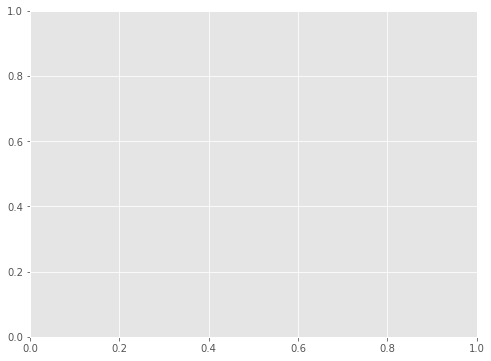

In [25]:
# Plot error vector's distance-to-center-pixel vs "true " error magnitude 
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_train,y_train, '.r')